## Logistic Regression

We implement a logistic regression model on the example data (​ex2data1.mat​)

- The Logistic regression hypothesis can be realized by the sigmoid function:

>  $h_{θ}$(x)= g($θ^{T}$x), g(z)= $\frac {1} {1 + (e^{-z})}$

- Then we vectorize the cost function.
- Then generate the decision boundary of example data via our logistic regression
model.
- And finally, plot the output boundary and the input data in the same figure.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plots
%config InlineBackend.figure_format = 'retina'
#plt.style.available # To check all available matplotlib styles
plt.style.use('seaborn-paper')

### Loading the dataset

In [33]:
# Loading the dataset
X_feat = []
y_target = []

with open('data/ex2data1.mat') as ex2_d1:
    for line in ex2_d1:
        line = line.strip().split(',')
        X_feat.append([float(line[0]), float(line[1])])
        y_target.append(float(line[2]))
        
X_feat = np.array(X_feat)
y_target = np.array(y_target)

### Visualizing the dataset

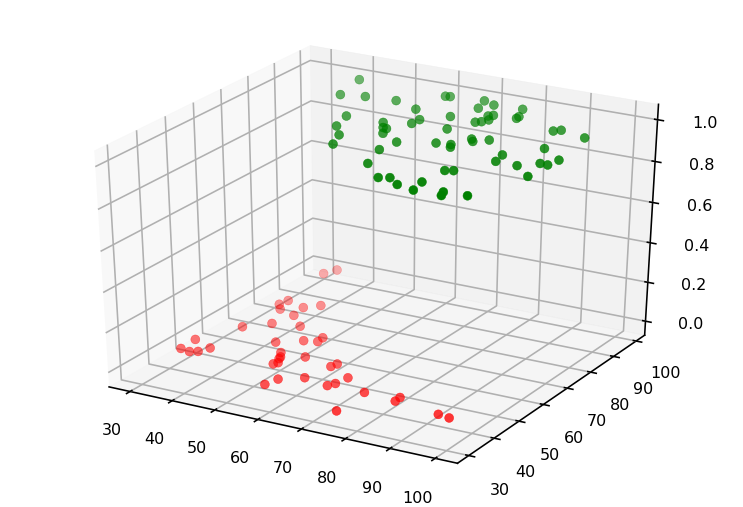

In [65]:
# Visualizing the dataset
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y_cmap = ['g' if i else 'r' for i in y_target] 
ax.scatter(xs=X_feat[:,0], ys=X_feat[:,1], zs=y_target, c=y_cmap)

plt.show()

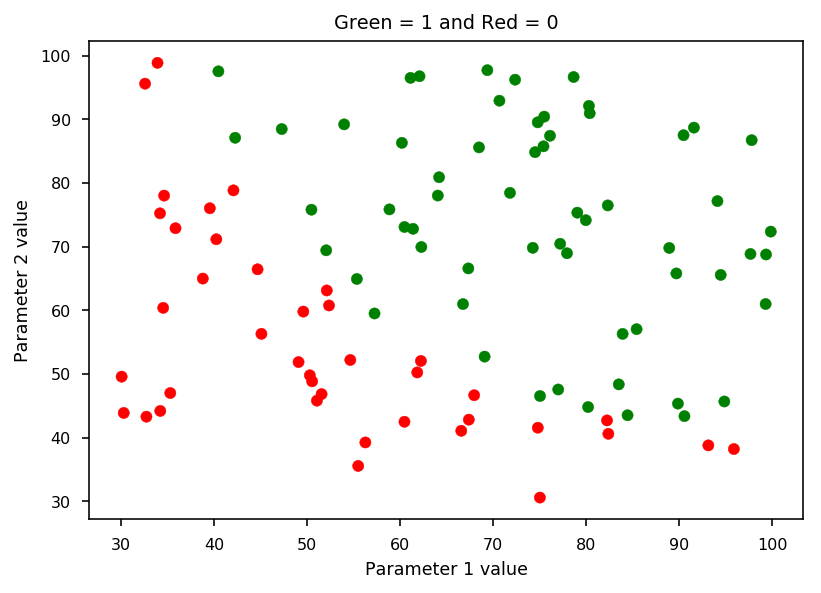

In [66]:
plt.scatter(X_feat[:,0], X_feat[:,1], c=y_cmap)
plt.xlabel("Parameter 1 value")
plt.ylabel("Parameter 2 value")
plt.title("Green = 1 and Red = 0")
plt.show()